In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('auto-mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
df.shape

(398, 9)

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [5]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [6]:
df['horsepower'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [7]:
print(df.shape)
df = df[df['horsepower'] != '?']
print(df.shape)

(398, 9)
(392, 9)


In [8]:
df['horsepower'] = df['horsepower'].astype(int)
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [9]:
df.nunique()

mpg             127
cylinders         5
displacement     81
horsepower       93
weight          346
acceleration     95
model year       13
origin            3
car name        301
dtype: int64

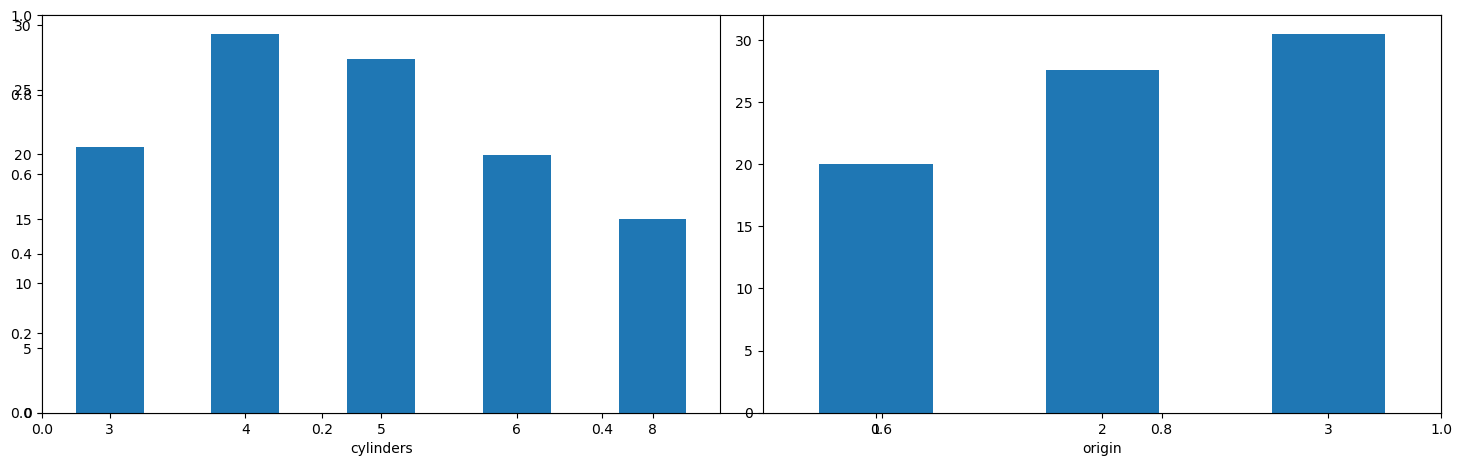

In [10]:
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])

plt.subplots(figsize=(15, 5))
for i, col in enumerate(['cylinders', 'origin']):
    plt.subplot(1, 2, i+1)
    x = numeric_df.groupby(col).mean()['mpg']
    x.plot.bar()
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

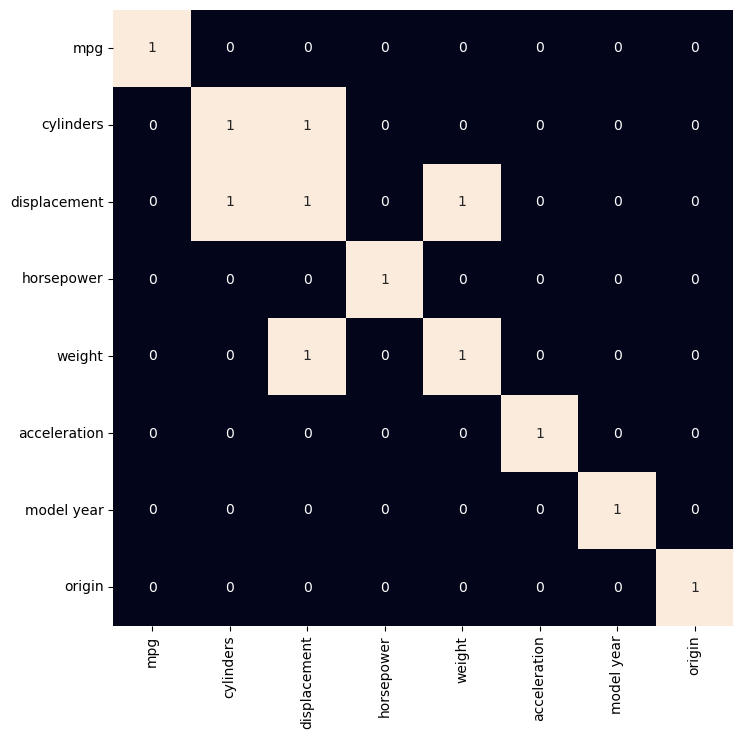

In [11]:
plt.figure(figsize=(8, 8)) 
sb.heatmap(numeric_df.corr() > 0.9, 
        annot=True, 
        cbar=False) 
plt.show()


In [12]:
df.drop('displacement',
        axis=1,
        inplace=True)

In [13]:
from sklearn.model_selection import train_test_split
features = df.drop(['mpg', 'car name'], axis=1)
target = df['mpg'].values

X_train, X_val, \
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.2,
                                      random_state=22)
X_train.shape, X_val.shape

((313, 6), (79, 6))

In [14]:
AUTO = tf.data.experimental.AUTOTUNE

train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .batch(32)
    .prefetch(AUTO)
)

In [15]:
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[6]),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='relu')
])

In [16]:
model.compile(
    loss='mae',
    optimizer='adam',
    metrics=['mape']
)

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,889 (273.00 KB)

 Trainable params: 68,865 (269.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [18]:
history = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 22.0198 - mape: 93.8866 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.6788 - mape: 82.6031 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.2077 - mape: 77.5905 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.9699 - mape: 73.2702 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.5292 - mape: 68.2412 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.3197 - mape: 64.1227 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.2737 - mape: 60.3248 - val_loss: 22.4190 - val_mape: 100.0000
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.5133 - mape: 57.4201 - val_loss: 22.4152 - val_mape: 99.9895
Epoch 9/50
10/10

In [19]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,mape,val_loss,val_mape
0,21.192900,90.949249,22.418987,100.0
1,18.385761,81.429924,22.418987,100.0
2,16.999325,76.615746,22.418987,100.0
3,15.722792,72.097580,22.418987,100.0
4,14.294497,67.030350,22.418987,100.0


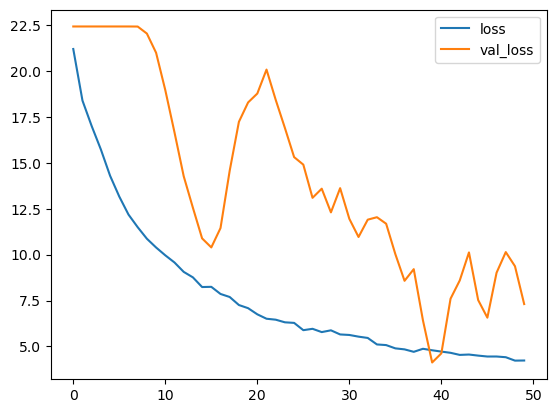

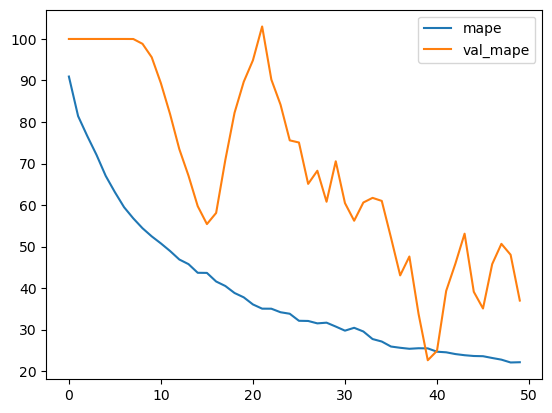

In [20]:
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['mape', 'val_mape']].plot()
plt.show()

In [21]:
from catboost import CatBoostRegressor, Pool
import pandas as pd

# Example training dataset
train_data = pd.DataFrame({
    'cylinders': [4, 6, 8],
    'displacement': [150, 200, 300],
    'horsepower': [100, 150, 200],
    'weight': [2500, 3000, 4000],
    'acceleration': [15, 12, 10],
    'model_year': [75, 80, 82],
    'origin': [1, 2, 3]
})
train_labels = [10, 15, 20]  # Example target values

# Specify the categorical column(s)
cat_features = ['origin']

# Train the model
model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6)

# Fit the model, passing cat_features explicitly
model.fit(train_data, train_labels, cat_features=cat_features)

# Save the model
model.save_model('fuel_consumption_model.cbm')  # Saves the model in the current directory

print("Model trained and saved successfully!")



0:	learn: 3.9804208	total: 157ms	remaining: 15.6s
1:	learn: 3.8912813	total: 167ms	remaining: 8.18s
2:	learn: 3.8057915	total: 180ms	remaining: 5.82s
3:	learn: 3.7106467	total: 201ms	remaining: 4.82s
4:	learn: 3.6307230	total: 213ms	remaining: 4.05s
5:	learn: 3.5448306	total: 230ms	remaining: 3.61s
6:	learn: 3.4685396	total: 246ms	remaining: 3.27s
7:	learn: 3.3818261	total: 270ms	remaining: 3.1s
8:	learn: 3.3017704	total: 284ms	remaining: 2.87s
9:	learn: 3.2192261	total: 304ms	remaining: 2.74s
10:	learn: 3.1443175	total: 319ms	remaining: 2.58s
11:	learn: 3.0657095	total: 341ms	remaining: 2.5s
12:	learn: 2.9890668	total: 362ms	remaining: 2.42s
13:	learn: 2.9143401	total: 376ms	remaining: 2.31s
14:	learn: 2.8477202	total: 386ms	remaining: 2.19s
15:	learn: 2.7765272	total: 400ms	remaining: 2.1s
16:	learn: 2.7071140	total: 413ms	remaining: 2.02s
17:	learn: 2.6394361	total: 424ms	remaining: 1.93s
18:	learn: 2.5734502	total: 433ms	remaining: 1.85s
19:	learn: 2.5091140	total: 444ms	remaining:

In [22]:
!pip install ipywidgets


Defaulting to user installation because normal site-packages is not writeable


In [23]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

# Assuming model is your pre-trained model
from catboost import CatBoostRegressor

# Load the trained model
model = CatBoostRegressor()
model.load_model('fuel_consumption_model.cbm')  # Replace with the actual path to your saved model

# Define widgets for user input
cylinders_widget = widgets.IntSlider(min=3, max=8, step=1, description='Cylinders:')
displacement_widget = widgets.FloatSlider(min=50, max=500, step=10, description='Displacement:')
horsepower_widget = widgets.FloatSlider(min=50, max=250, step=10, description='Horsepower:')
weight_widget = widgets.FloatSlider(min=1500, max=5500, step=100, description='Weight:')
acceleration_widget = widgets.FloatSlider(min=8, max=24, step=1, description='Acceleration:')
model_year_widget = widgets.IntSlider(min=70, max=82, step=1, description='Model Year:')
origin_widget = widgets.Dropdown(options=[1, 2, 3], description='Origin:')

# Define function to preprocess input and make predictions
def predict_fuel_consumption(cylinders, displacement, horsepower, weight, acceleration, model_year, origin):
    # Prepare input data
    input_data = pd.DataFrame({
        'cylinders': [cylinders],
        'displacement': [displacement],
        'horsepower': [horsepower],
        'weight': [weight],
        'acceleration': [acceleration],
        'model_year': [model_year],
        'origin': [origin]  # Process origin as needed
    })
    
    # Process 'origin' if necessary (e.g., one-hot encoding)
    # Assuming the model expects origin to be one-hot encoded
    origin_encoded = pd.get_dummies(input_data['origin'], prefix='origin')
    input_data = pd.concat([input_data.drop('origin', axis=1), origin_encoded], axis=1)

    # Ensure input shape matches the model's requirements
    required_columns = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
    for col in origin_encoded.columns:
        required_columns.append(col)
    
    # Add missing columns with default value 0
    for col in required_columns:
        if col not in input_data:
            input_data[col] = 0

    input_data = input_data[required_columns]  # Ensure column order matches training data

    # Make a prediction
    try:
        prediction = model.predict(input_data)[0]
        print(f'Predicted Fuel Consumption: {prediction:.2f} liters/100km')
    except Exception as e:
        print(f"Error making prediction: {e}")

# Display widgets
interactive_plot = widgets.interactive(
    predict_fuel_consumption,
    cylinders=cylinders_widget,
    displacement=displacement_widget,
    horsepower=horsepower_widget,
    weight=weight_widget,
    acceleration=acceleration_widget,
    model_year=model_year_widget,
    origin=origin_widget
)

display(interactive_plot)


interactive(children=(IntSlider(value=3, description='Cylinders:', max=8, min=3), FloatSlider(value=50.0, desc…

In [24]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import pickle
from catboost import CatBoostRegressor

# Load the trained model
model = CatBoostRegressor()
model.load_model('fuel_consumption_model.cbm')  # Replace with the actual path to your saved model

# Define widgets for user input
cylinders_widget = widgets.IntSlider(min=3, max=8, step=1, description='Cylinders:')
displacement_widget = widgets.FloatSlider(min=50, max=500, step=10, description='Displacement:')
horsepower_widget = widgets.FloatSlider(min=50, max=250, step=10, description='Horsepower:')
weight_widget = widgets.FloatSlider(min=1500, max=5500, step=100, description='Weight:')
acceleration_widget = widgets.FloatSlider(min=8, max=24, step=1, description='Acceleration:')
model_year_widget = widgets.IntSlider(min=70, max=82, step=1, description='Model Year:')
origin_widget = widgets.Dropdown(options=[1, 2, 3], description='Origin:')

# Define function to preprocess input and make predictions
def predict_fuel_consumption(cylinders, displacement, horsepower, weight, acceleration, model_year, origin):
    # Prepare input data
    input_data = pd.DataFrame({
        'cylinders': [cylinders],
        'displacement': [displacement],
        'horsepower': [horsepower],
        'weight': [weight],
        'acceleration': [acceleration],
        'model_year': [model_year],
        'origin': [origin]
    })

    # Process 'origin' if necessary (e.g., one-hot encoding)
    origin_encoded = pd.get_dummies(input_data['origin'], prefix='origin')
    input_data = pd.concat([input_data.drop('origin', axis=1), origin_encoded], axis=1)

    # Ensure input shape matches the model's requirements
    required_columns = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
    for col in origin_encoded.columns:
        required_columns.append(col)

    # Add missing columns with default value 0
    for col in required_columns:
        if col not in input_data:
            input_data[col] = 0

    input_data = input_data[required_columns]  # Ensure column order matches training data

    # Make a prediction
    try:
        prediction = model.predict(input_data)[0]
        print(f'Predicted Fuel Consumption: {prediction:.2f} liters/100km')
    except Exception as e:
        print(f"Error making prediction: {e}")

# Save widget state to a file
def save_widget_state():
    widget_state = {
        'cylinders': cylinders_widget.value,
        'displacement': displacement_widget.value,
        'horsepower': horsepower_widget.value,
        'weight': weight_widget.value,
        'acceleration': acceleration_widget.value,
        'model_year': model_year_widget.value,
        'origin': origin_widget.value
    }
    with open('widget_state.pkl', 'wb') as f:
        pickle.dump(widget_state, f)

# Load widget state from a file
def load_widget_state():
    try:
        with open('widget_state.pkl', 'rb') as f:
            widget_state = pickle.load(f)
            # Update widget values from saved state
            cylinders_widget.value = widget_state['cylinders']
            displacement_widget.value = widget_state['displacement']
            horsepower_widget.value = widget_state['horsepower']
            weight_widget.value = widget_state['weight']
            acceleration_widget.value = widget_state['acceleration']
            model_year_widget.value = widget_state['model_year']
            origin_widget.value = widget_state['origin']
    except FileNotFoundError:
        print("No saved widget state found. Displaying default values.")

# Load state when the notebook is opened
load_widget_state()

# Display widgets
interactive_plot = widgets.interactive(
    predict_fuel_consumption,
    cylinders=cylinders_widget,
    displacement=displacement_widget,
    horsepower=horsepower_widget,
    weight=weight_widget,
    acceleration=acceleration_widget,
    model_year=model_year_widget,
    origin=origin_widget
)

display(interactive_plot)

# Save the widget state on changes (call this whenever needed)
save_widget_state()


interactive(children=(IntSlider(value=3, description='Cylinders:', max=8, min=3), FloatSlider(value=50.0, desc…